In [313]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from stargazer.stargazer import Stargazer
import scipy.stats as stats
import seaborn as sns
import os

In [314]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"
temporary = "temporary_data\\"
final_scripts = "final_scripts\\"
normalized_dataframes = "normalized_dataframes\\"
college_matching = "college_matching\\"
regression = "regression\\"
normalized_dataframes = "normalized_dataframes\\"
normalized_regression_boards = "normalized_regression_boards\\"
network = "network\\"
network_boards = "network_boards\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"
temporary_data_path = f"{absolute_path}{temporary}"

years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]


In [315]:
def remove_non_samples(df):
    df = df[df['PrimarySample'] == True]
    return df

In [316]:
university_stats_path = os.path.join(absolute_path, final_scripts, regression, "regression_stats\\regression_university_board_statistics.csv")
school_stats_path = os.path.join(absolute_path, final_scripts, regression, "regression_stats\\university_statistics_for_regression_new.csv")

university_board_statistics_df = pd.read_csv(university_stats_path)
school_statistics_df = pd.read_csv(school_stats_path)

In [317]:
#normalize proportions for the regression

university_board_statistics_df['female_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['female'] / row['total_members'] if row['total_members'] > 0 else 0,
             axis=1
         )

university_board_statistics_df['poc_proportion'] = \
         university_board_statistics_df.apply(
             lambda row: row['poc'] / row['total_ethnicity'] if row['total_ethnicity'] > 0 else 0,
             axis=1
         )

# Calculate the proportion of billionaires on the board
university_board_statistics_df['billionaire_proportion'] = (
    university_board_statistics_df['num_billionaires'] / 
    university_board_statistics_df['total_members'].replace(0, np.nan)
).fillna(0)




In [318]:
print(school_statistics_df.columns)
school_statistics_df.rename(columns={"year": "Year"}, inplace = True)

university_board_statistics_df["Year"] = university_board_statistics_df["Year"].astype(int)
university_board_statistics_df["carnegie_id"] = (
    pd.to_numeric(university_board_statistics_df["carnegie_id"], errors="coerce")
    .astype(int)
    .astype(str)
)

school_statistics_df["Year"] = school_statistics_df["Year"].astype(int)
#for the affiliation id
# school_statistics_df["carnegie_id"] = (
#     school_statistics_df["carnegie_id"].astype(str).str[1:]
# )
school_statistics_df["carnegie_id"] = school_statistics_df["carnegie_id"].astype(str)

# Define the columns to merge from school_statistics_df (including the keys)
columns_to_merge = [
    "Year",
    "carnegie_id",
    "student.women",
    "faculty.women",
    "faculty.race_ethnicity.white",
    "student.size",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

# Create a subset of school_statistics_df with only the desired columns
school_subset = school_statistics_df[columns_to_merge]

# Drop the non-key columns from university_board_statistics_df if they already exist to avoid duplicates
for col in ["student.women", "faculty.women", "faculty.race_ethnicity.white", "student.size", "cost.tuition.out_of_state", "school.faculty_salary", "RD_expenditure"]:
    if col in university_board_statistics_df.columns:
        university_board_statistics_df.drop(columns=[col], inplace=True)


# Merge the school statistics onto university_board_statistics_df based on Year and AffiliationId
university_board_statistics_df = university_board_statistics_df.merge(
    school_subset,
    on=["Year", "carnegie_id"],
    how="left"
)


university_board_statistics_df.drop_duplicates(subset=["Year", "AffiliationId"], inplace=True)
university_board_statistics_df.drop_duplicates(subset=["Year", "Institution"], inplace=True)

university_board_statistics_df.to_csv(university_stats_path, index = False)

Index(['school.name', 'carnegie_id', 'year', 'school.carnegie_basic',
       'student.women', 'faculty.women', 'faculty.race_ethnicity.white',
       'student.size', 'cost.tuition.in_state', 'cost.tuition.out_of_state',
       'school.faculty_salary', 'RD_expenditure'],
      dtype='object')


In [319]:
print(university_board_statistics_df.columns)

Index(['Year', 'Institution', 'AffiliationId', 'female_president',
       'PrimarySample', 'total_members', 'male', 'female', 'unknown',
       'total_ethnicity', 'white', 'poc', 'unknown_eth', 'board_turnover',
       'male_change', 'female_change', 'unknown_change', 'white_change',
       'poc_change', 'unknown_eth_change', 'carnegie_id', 'state', 'control',
       'StateSystem', 'region', 'num_billionaires', 'eigenvector',
       'betweenness', 'degree', 'strength', 'female_proportion',
       'poc_proportion', 'billionaire_proportion', 'student.women',
       'faculty.women', 'faculty.race_ethnicity.white', 'student.size',
       'cost.tuition.out_of_state', 'school.faculty_salary', 'RD_expenditure'],
      dtype='object')


In [320]:
aff_ids_with_na = (
    university_board_statistics_df
    .groupby("AffiliationId")
    .filter(lambda group: group.isna().any().any())["AffiliationId"]
    .unique()
)
print(aff_ids_with_na)

# Drop all rows with these AffiliationIds
clean_df = university_board_statistics_df[
    ~university_board_statistics_df["AffiliationId"].isin(aff_ids_with_na)
].copy()


university_board_statistics_df = clean_df


[ 71965598 102298084  82497590 152479009  16285277 139290212  86420138
 172980758  26347476  35566140 115475287 126863827 130769515 219193219
  44265643 102322142 142823887 206651237  96749437 164185940 150913223
 162281398    708430  27837315  71966907 119942576 155781252 161515732
  51556381 201448701 102401767  79620101 156087764 180670191 921990950
 166722992  59130452  11874761 160606119  75027704 919571938 165951966
  55302922 221716585 200719446 138659443  19772626]


In [321]:
'''Logistic Regression'''

dependent_var = "female_president"
year_var = "Year"

# Original list of independent variables.
# Note: "region" and "control" will be one-hot encoded.
independent_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "control",
    "faculty.women",
    "region",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

# When dropping missing data, drop on the columns that exist in the original DataFrame.
# We exclude any future dummy columns and drop on the original ones.
cols_to_check = [dependent_var] + independent_vars + [year_var, "region", "control"]

regression_data = university_board_statistics_df.dropna(subset=cols_to_check).copy()

# Ensure the dependent variable is binary.
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# One-hot encode Year, region, and control.
# drop_first=True avoids the dummy variable trap.
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var, "region", "control"],
    drop_first=True
)

# Identify the dummy columns for Year, region, and control.
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
region_dummies = [col for col in regression_data.columns if col.startswith("region_")]
control_dummies = [col for col in regression_data.columns if col.startswith("control_")]

# Build the full predictor list.
# Remove the original "region" and "control" from independent_vars and add our new dummy variables.
predictor_vars = [var for var in independent_vars if var not in ["region", "control"]] \
                 + year_dummies + region_dummies + control_dummies

X = regression_data[predictor_vars]
y = regression_data[dependent_var]

# Ensure all predictor columns are numeric.
X = X.apply(pd.to_numeric, errors='raise')

# Normalize continuous predictors.
# Exclude dummy variables (for year, region, and control) from scaling.
continuous_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

scaler = StandardScaler()
vars_to_scale = [var for var in continuous_vars if var in X.columns]
X_scaled = X.copy()
X_scaled[vars_to_scale] = scaler.fit_transform(X_scaled[vars_to_scale])

# Ensure the scaled data is numeric.
X_scaled = X_scaled.apply(pd.to_numeric, errors='raise')

# Add an intercept.
X_scaled = sm.add_constant(X_scaled)
# Force all columns to float to avoid object dtype errors.
X_scaled = X_scaled.astype(float)

# Fit the logistic regression model.
logit_model = sm.Logit(y, X_scaled)
result = logit_model.fit()

# Create a DataFrame with odds ratios and p-values.
odds_ratios = pd.DataFrame({
    "Variable": X_scaled.columns,
    "Coefficient": result.params,
    "Odds Ratio": np.exp(result.params),
    "P-Value": result.pvalues
})

print(result.summary())
print("\nOdds Ratios and P-Values:")
print(tabulate(odds_ratios, headers="keys", tablefmt="grid"))

# Calculate Variance Inflation Factors (VIF).
if 'const' in X_scaled.columns:
    X_check = X_scaled.drop('const', axis=1)
else:
    X_check = X_scaled.copy()

vif_data = pd.DataFrame({
    "Variable": X_check.columns,
    "VIF": [variance_inflation_factor(X_check.values, i) for i in range(X_check.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(tabulate(vif_data, headers="keys", tablefmt="grid"))

Optimization terminated successfully.
         Current function value: 0.254802
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:       female_president   No. Observations:                 1593
Model:                          Logit   Df Residuals:                     1565
Method:                           MLE   Df Model:                           27
Date:                Sun, 16 Feb 2025   Pseudo R-squ.:                  0.1220
Time:                        15:41:24   Log-Likelihood:                -405.90
converged:                       True   LL-Null:                       -462.30
Covariance Type:            nonrobust   LLR p-value:                 1.854e-12
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.7359      0.514     -5.318      0.000

In [322]:
# Define the dependent variable and the year variable.
dependent_var = "female_president"
year_var = "Year"

# Updated full list of independent variables.
independent_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "control",
    "faculty.women",
    "region",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

# Drop rows missing any of the variables used in any model.
cols_to_check = [dependent_var, year_var] + independent_vars
regression_data = university_board_statistics_df.dropna(subset=cols_to_check).copy()

# Ensure the dependent variable is binary.
regression_data[dependent_var] = regression_data[dependent_var].astype(int)

# One-hot encode Year, region, and control.
# (Using drop_first=True to avoid the dummy variable trap.)
regression_data = pd.get_dummies(
    regression_data,
    columns=[year_var, "region", "control"],
    drop_first=True
)

# Identify dummy columns.
year_dummies = [col for col in regression_data.columns if col.startswith(f"{year_var}_")]
region_dummies = [col for col in regression_data.columns if col.startswith("region_")]
control_dummies = [col for col in regression_data.columns if col.startswith("control_")]

# Define continuous variables to be scaled.
continuous_vars = [
    "student.women", 
    "student.size", 
    "female_proportion",
    "billionaire_proportion",
    "total_members",
    "betweenness",
    "degree",
    "faculty.race_ethnicity.white",
    "poc_proportion",
    "board_turnover",
    "faculty.women",
    "strength",
    "cost.tuition.out_of_state",
    "school.faculty_salary",
    "RD_expenditure"
]

# Standardize continuous variables.
scaler = StandardScaler()
vars_to_scale = [var for var in continuous_vars if var in regression_data.columns]
regression_data[vars_to_scale] = scaler.fit_transform(regression_data[vars_to_scale])


model1_vars = ["student.size", "student.women", "cost.tuition.out_of_state"]

model2_vars = model1_vars + [
    "faculty.women", 
    "faculty.race_ethnicity.white", 
    "billionaire_proportion", 
    "school.faculty_salary", 
    "RD_expenditure"
]

model3_vars = model2_vars + ["female_proportion", "board_turnover", "total_members", "poc_proportion"]

model4_vars = model3_vars + ["betweenness", "degree", "strength"]

def add_dummies(predictors):
    return predictors + region_dummies + control_dummies + year_dummies

model_specs = [
    add_dummies(model1_vars),
    add_dummies(model2_vars),
    add_dummies(model3_vars),
    add_dummies(model4_vars)
]


models = []
for spec in model_specs:
    X = regression_data[spec]
    # Add a constant and convert all predictors to float.
    X = sm.add_constant(X)
    X = X.astype(float)
    y = regression_data[dependent_var].astype(float)
    model = sm.Logit(y, X).fit(disp=False)
    models.append(model)

# Generate Stargazer output for the regression results.
stargazer = Stargazer(models)
stargazer.title("Logistic Regression Results: Sequential Model Building")
stargazer.dependent_variable_name(dependent_var)

# Render LaTeX output.
print(stargazer.render_latex())


\begin{table}[!htbp] \centering
  \caption{Logistic Regression Results: Sequential Model Building}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: female_president}} \
\cr \cline{2-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 RD_expenditure & & -0.507$^{***}$ & -0.490$^{***}$ & -0.539$^{***}$ \\
& & (0.173) & (0.179) & (0.183) \\
 Year_2000 & 0.006$^{}$ & 0.001$^{}$ & 0.082$^{}$ & 0.163$^{}$ \\
& (0.445) & (0.448) & (0.479) & (0.483) \\
 Year_2005 & 0.379$^{}$ & 0.419$^{}$ & 0.458$^{}$ & 0.521$^{}$ \\
& (0.433) & (0.466) & (0.485) & (0.486) \\
 Year_2007 & 0.231$^{}$ & 0.187$^{}$ & 0.224$^{}$ & 0.248$^{}$ \\
& (0.456) & (0.510) & (0.535) & (0.537) \\
 Year_2008 & 0.150$^{}$ & 0.078$^{}$ & 0.189$^{}$ & 0.265$^{}$ \\
& (0.471) & (0.538) & (0.573) & (0.577) \\
 Year_2009 & 0.327$^{}$ & 0.281$^{}$ & 0.394$^{}$ & 0.436$^{}$ \\
& (0.466) & (0.549) & (0.580) & (0.582) \\
 Year_2011 & 0.257$^{}$ & 0.1

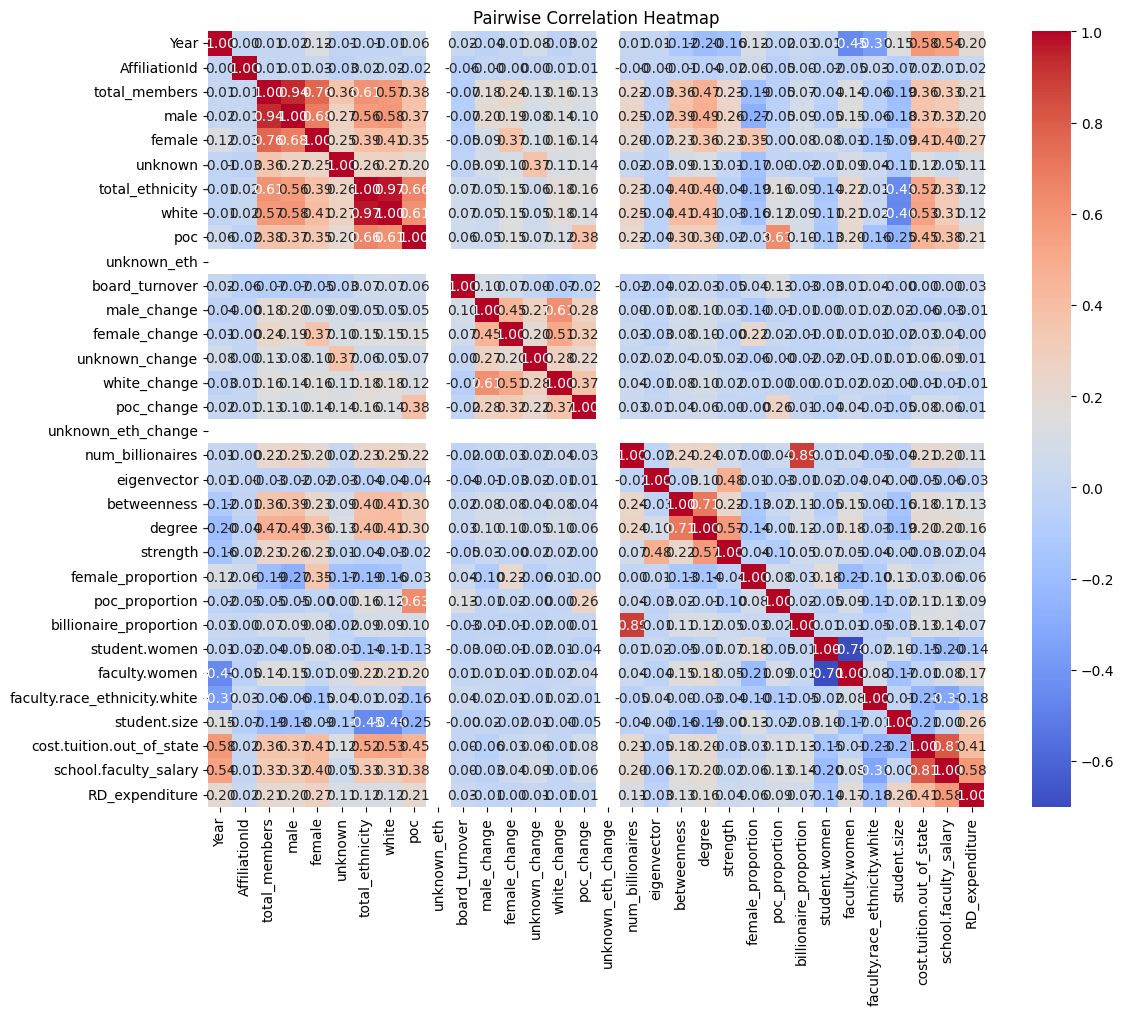

In [323]:
numeric_df = clean_df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pairwise Correlation Heatmap")
plt.tight_layout()
plt.show()